# Sarcasm detection - MAIN CAS, modules text analytics and big data, Rita Fleer

This script shows a much simpler model based on https://www.kaggle.com/code/ashfakyeafi/sarcasm-detection. Headlines are padded at length 7 already, which means, a lot of information is lost. The model has much nicer loss and accuracy curves but the validation accuracy is much lower.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from nltk.corpus import stopwords 
import re
import nltk
from wordcloud import WordCloud
nltk.download("stopwords")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import optuna
import time

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-12-27 06:59:18.309007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 06:59:18.309040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 06:59:18.309065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 06:59:18.315669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other

In [2]:
data = pd.read_json("data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
del data['article_link'] # Deleting this column as it is of no use


data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [3]:


def find_num_words(data):
    wordlist = []
    splitting_list = data.str.split()
    for i in range(len(splitting_list)):
        for j in range(len(splitting_list[i])):
            wordlist.append(splitting_list[i][j])
            
    wordset = set(wordlist)
    
    print(len(wordset),len(wordlist))

find_num_words(data.headline)



38234 287620


In [4]:
#Removing punctiation marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing special characters
def remove_specialchars(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


#Total function
def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

data['headline']=data['headline'].apply(cleaning)

In [5]:
sentences = data["headline"].values.tolist()
target = data["is_sarcastic"].values.tolist()

In [6]:


num_words = 1000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(sentences)
tokens = tokenizer.texts_to_sequences(sentences)

numTokens = [len(token) for token in tokens]
numTokens = np.array(numTokens)
print("Tokens'mean",np.mean(numTokens))
print("Max", np.max(numTokens))
print("Argmax", np.argmax(numTokens))



Tokens'mean 3.7437017366085468
Max 31
Argmax 7302


In [7]:
max_tokens = int(np.mean(numTokens) + 2*np.std(numTokens))
print("Calculated maximum number of tokens :",max_tokens)
print("What percentage of the data fits this average? :",np.sum(numTokens < max_tokens) / len(numTokens))

Calculated maximum number of tokens : 7
What percentage of the data fits this average? : 0.9099898668716587


In [8]:


padding_data = pad_sequences(tokens, maxlen=max_tokens)
print(padding_data.shape)
print(len(target))



(28619, 7)
28619


In [9]:
X_train, X_test, y_train, y_test = train_test_split(padding_data, data.is_sarcastic, random_state=1, test_size=0.15, stratify=data.is_sarcastic)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.1, stratify=y_train)

In [10]:
EMBEDDING_SIZE = 40

model = Sequential()
model.add(Embedding(input_dim = num_words,
                    output_dim=EMBEDDING_SIZE,
                    input_length=max_tokens,
                    name='embedding_layer'))
model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(l=1.367675698620851e-05)))
model.add(GRU(units=32))
#model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2023-12-27 07:00:02.972912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 07:00:02.979736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 07:00:02.980079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 7, 40)             40000     
 )                                                               
                                                                 
 gru (GRU)                   (None, 7, 128)            65280     
                                                                 
 gru_1 (GRU)                 (None, 7, 64)             37248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 151969 (593.63 KB)
Trainable params: 151969 (593.63 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [11]:


model.compile(loss="binary_crossentropy", optimizer = RMSprop(learning_rate=8.74355057651944e-05), metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=40)



Epoch 1/30


2023-12-27 07:00:12.400942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-27 07:00:12.836064: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f767c57ae40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 07:00:12.836098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-12-27 07:00:12.841041: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-27 07:00:12.907677: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 [==============================] - 11s 15ms/step - loss: 0.6937 - accuracy: 0.5238 - val_loss: 0.6895 - val_accuracy: 0.5816
Epoch 2/30
548/548 [==============================] - 3s 6ms/step - loss: 0.6609 - accuracy: 0.6210 - val_loss: 0.6079 - val_accuracy: 0.6658
Epoch 3/30
548/548 [==============================] - 3s 6ms/step - loss: 0.5753 - accuracy: 0.6950 - val_loss: 0.5642 - val_accuracy: 0.7028
Epoch 4/30
548/548 [==============================] - 3s 6ms/step - loss: 0.5391 - accuracy: 0.7240 - val_loss: 0.5384 - val_accuracy: 0.7213
Epoch 5/30
548/548 [==============================] - 3s 6ms/step - loss: 0.5207 - accuracy: 0.7343 - val_loss: 0.5323 - val_accuracy: 0.7308
Epoch 6/30
548/548 [==============================] - 3s 6ms/step - loss: 0.5115 - accuracy: 0.7405 - val_loss: 0.5317 - val_accuracy: 0.7283
Epoch 7/30
548/548 [==============================] - 3s 6ms/step - loss: 0.5061 - accuracy: 0.7447 - val_loss: 0.5259 - val_accuracy: 0.7312
Epoch 8/30
548/

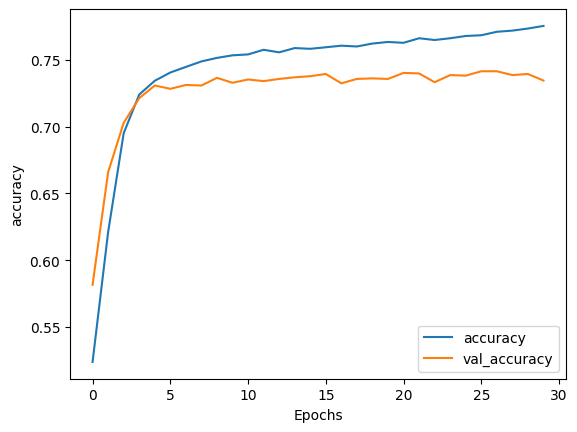

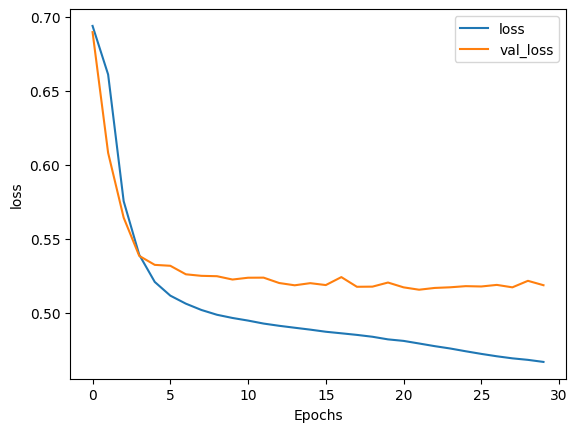

In [12]:


import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

